# Classification of CNT Nanoimages

This project is being done to classify CNT nanoimages taken from the university chemistrical labs. For improving the progress, we've divided this work into 3 aproaches.

First approach is supervised classification. Labels are known (two labels exist) and classification is done by finite number of train images (100 images). This work is basicaly prominent for initiating our effort, however the forwarding approachs are required for putting it forward.

Second approach comes out of our necessity of large amount of train images. There is a generative work before the classification. Our work is still supervised but with large amount of generated train samples, we have more accuracy. Moreover we will work with a different  predefined configuration of layers using a popular network.

Last approach is to use a totaly different network called capsule. We expect different results from it and we take account into this variety.

Let's start first one!

# Approach One: Convolutional Neural Networks

In the first approach, we've build a deep learning model using Keras. The model is a convolutional neural network built into several layers. Train and test data is a group of jpg images that you can see one of them below. Images are being grayscale and resized as 500 x 300 pixels. 

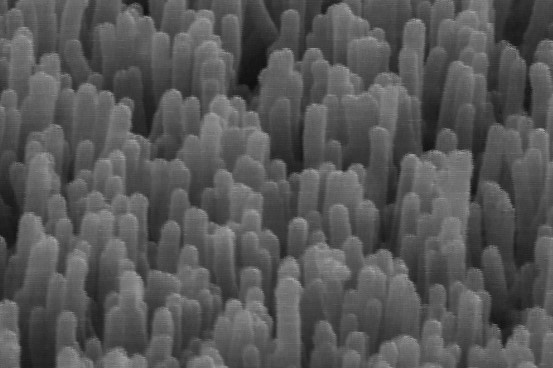

Coding and evaluating model is shown below.

In [3]:
# Importing related libraries
import numpy as np
import pandas as pd
import keras
import cv2
import glob
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.applications import VGG19
# Adjusting Import Directory
cwd = os.getcwd()
os.chdir("C:/Users/toranj/Desktop/DL Python")

E:\Software\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Sharpening is a work on pictures that make them more constrasting and our model will take into the defining the features with more ease. We will sharpen the image using "unsharp mask" method with applying a gaussian blur filter to the original image and substracting it from the original one with a predetermined weight called "sharpfactor" (that is input to the function).

In [4]:
## Predefined functions
 
# Sharpfactor is an int betweeen 0 and 1 determines how much high the result is to be sharpened.
def sharpen(img,sharpfactor):
    threshold = 0.5
    blurred = cv2.GaussianBlur(img,ksize = (3,3),sigmaX=0)
    masked = np.abs(img - blurred) < threshold
    image = cv2.addWeighted(blurred, -sharpfactor, img , (1+sharpfactor), gamma = 0)
    binmasked = masked.astype(bool)
    image = image * (binmasked.astype(image.dtype))
    return image
                                    

In [6]:
# Loading train images
image_path = "C:/Users/toranj/Desktop/DL Python/CNT/"          # path of train images
images = glob.glob(image_path +"*.jpg")                        # selecting images
images.sort()                                                  # sorting images
final_images=[]
for img in images:    
    image = cv2.imread(img,0)                          # loading images
    image = cv2.resize(image,(500,300))                # resizing images
    image = image / np.max(image)                      # Normalization
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    #image = clahe.apply(image)
    image = sharpen(image,0.8)
    image = image.tolist()
    final_images.append(image)

In [7]:
# loading train labels
labels = pd.read_excel("CNT Labels.xlsx")
final_labels = labels.values.tolist()
# split data
img_train, img_test, lbl_train, lbl_test = train_test_split(final_images, final_labels,
                                                            test_size=0.2, random_state=42, stratify=final_labels)

In [28]:
# Creating Convolutional Model
def BuildModel():
    CNT_Model = Sequential()
    
    reg = regularizers.l1_l2(l1 = 0.001, l2 = 0.002)
    
    CNT_Model.add(Conv2D(20,5, activation = 'relu',strides=3, padding = 'same',kernel_regularizer = None, input_shape =(300,500,1)))
    CNT_Model.add(Conv2D(20,5, activation = 'relu',strides=2, padding = 'same', kernel_regularizer = None))
    CNT_Model.add(MaxPooling2D(pool_size = (2,2)))
    #CNT_Model.add(Dropout(0.8))
    CNT_Model.add(Conv2D(40,5, activation = 'relu', padding = 'same', kernel_regularizer = None))
    CNT_Model.add(MaxPooling2D(pool_size = (2,2)))
    CNT_Model.add(Conv2D(40,5, activation = 'relu', padding = 'same', kernel_regularizer = None))
    #CNT_Model.add(Dropout(0.5))
    CNT_Model.add(Flatten())
    CNT_Model.add(Dense(15,activation = 'relu', kernel_regularizer =None))       
    #CNT_Model.add(Dropout(0.5))
    #CNT_Model.add(BatchNormalization())
    CNT_Model.add(Dense(8,activation = 'relu', kernel_regularizer = None))
    #CNT_Model.add(BatchNormalization())
    CNT_Model.add(Dense(2,activation='sigmoid'))

    Optimizer = keras.optimizers.SGD(lr=0.01, momentum = 0.5, decay = 1e-5, nesterov = True)
   
    CNT_Model.compile(optimizer=Optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return CNT_Model
CNT_Model = BuildModel()
CNT_Model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 100, 167, 20)      520       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 50, 84, 20)        10020     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 25, 42, 20)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 25, 42, 40)        20040     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 12, 21, 40)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 12, 21, 40)        40040     
_________________________________________________________________
flatten_9 (Flatten)          (None, 10080)             0         
__________

In [29]:
# Training model
img_train = np.reshape(img_train,(len(img_train),300,500,1))

ann_hist = CNT_Model.fit(np.array(img_train), np.array(lbl_train), validation_split = 0.1, batch_size = 3, epochs = 100)

Train on 72 samples, validate on 8 samples
Epoch 1/100
72/72 [==============================] - 2s 32ms/step - loss: 0.6932 - acc: 0.4722 - val_loss: 0.7060 - val_acc: 0.2500
Epoch 2/100
72/72 [==============================] - 2s 27ms/step - loss: 0.6890 - acc: 0.5694 - val_loss: 0.7224 - val_acc: 0.2500
Epoch 3/100
72/72 [==============================] - 2s 26ms/step - loss: 0.6878 - acc: 0.5694 - val_loss: 0.7390 - val_acc: 0.2500
Epoch 4/100
72/72 [==============================] - 2s 25ms/step - loss: 0.6848 - acc: 0.5694 - val_loss: 0.7595 - val_acc: 0.2500
Epoch 5/100
72/72 [==============================] - 2s 25ms/step - loss: 0.6843 - acc: 0.5694 - val_loss: 0.7634 - val_acc: 0.2500
Epoch 6/100
72/72 [==============================] - 2s 25ms/step - loss: 0.6864 - acc: 0.5694 - val_loss: 0.7472 - val_acc: 0.2500
Epoch 7/100
72/72 [==============================] - 2s 25ms/step - loss: 0.6844 - acc: 0.5694 - val_loss: 0.7552 - val_acc: 0.2500
Epoch 8/100
72/72 [==============

72/72 [==============================] - 2s 29ms/step - loss: 0.1771 - acc: 0.9306 - val_loss: 1.1765 - val_acc: 0.6250
Epoch 63/100
72/72 [==============================] - 2s 27ms/step - loss: 0.1011 - acc: 0.9583 - val_loss: 2.8137 - val_acc: 0.2500
Epoch 64/100
72/72 [==============================] - 2s 27ms/step - loss: 0.1936 - acc: 0.9167 - val_loss: 0.7554 - val_acc: 0.5000
Epoch 65/100
72/72 [==============================] - 2s 29ms/step - loss: 0.1568 - acc: 0.9306 - val_loss: 1.0060 - val_acc: 0.5000
Epoch 66/100
72/72 [==============================] - 2s 26ms/step - loss: 0.0742 - acc: 0.9722 - val_loss: 1.9601 - val_acc: 0.2500
Epoch 67/100
72/72 [==============================] - 2s 27ms/step - loss: 0.0296 - acc: 1.0000 - val_loss: 1.5532 - val_acc: 0.6250
Epoch 68/100
72/72 [==============================] - 2s 27ms/step - loss: 0.0121 - acc: 1.0000 - val_loss: 2.3795 - val_acc: 0.5000
Epoch 69/100
72/72 [==============================] - 2s 25ms/step - loss: 0.0026 

In [10]:
# Model Evaluation
img_test = np.reshape(img_test,(len(img_test),300,500,1))
test_loss, test_acc = CNT_Model.evaluate(np.array(img_test), np.array(lbl_test), batch_size = 3)
labels_predicted = CNT_Model.predict(np.array(img_test))
lbl= np.argmax(labels_predicted, axis=1)
print('Test loss is',test_loss)
print('Test accuracy is',test_acc)

20/20 [==============================] - 0s 9ms/step
Test loss is 5.453091967105865
Test accuracy is 0.40000001192092893


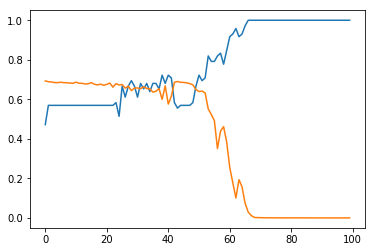

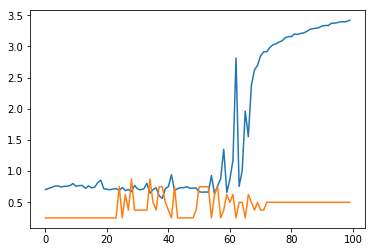

In [30]:
# Plotting results
def ploth(ann_hist):
    plt.figure()
    hist = ann_hist.history
    loss = hist['loss']
    acc = hist['acc']
    plt.plot(acc)
    plt.plot(loss)
    plt.figure()
    val_loss = hist['val_loss']
    val_acc = hist['val_acc']
    plt.plot(val_loss)
    plt.plot(val_acc)
    plt.xlabel=('Epoch')
    plt.ylabel=('Loss')
ploth(ann_hist)

# Using Cross Validation to Improve Error
We use k-fold cross validation with k = 4 since we have a few amount of data to train and this technique will help us to see better results.

In [19]:
# K-fold cross validation
k = 4
num_val_samples = len(img_train) // k
epochs = 100
all_scores = []

for i in range(k):
    print('Training process of fold #{0} is going on.'.format(i))
    val_data = img_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = lbl_train[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = img_train[:num_val_samples * k] + img_train[num_val_samples * (k + 1):]
    
    partial_train_targets = lbl_train[:num_val_samples * k] + lbl_train[num_val_samples * (k + 1):]
    
    model = BuildModel()
    
    partial_train_data = np.reshape(partial_train_data,(len(partial_train_data),300,500,1))
    
    model.fit(np.array(partial_train_data), np.array(partial_train_targets),
    epochs=epochs, batch_size=3, verbose=0)
    
    val_data = np.reshape(val_data,(len(val_data),300,500,1))

    val_mse, val_mae = model.evaluate(np.array(val_data), np.array(val_targets))
    all_scores.append(val_mse)
total_error = np.average(all_scores)
print('The validation mean error is',total_error)

Training process of fold #0 is going on.
20/20 [==============================] - 0s 11ms/step
Training process of fold #1 is going on.
20/20 [==============================] - 0s 12ms/step
Training process of fold #2 is going on.
20/20 [==============================] - 0s 12ms/step
Training process of fold #3 is going on.
20/20 [==============================] - 0s 13ms/step
The validation mean error is 0.7830491662025452


# Approach Two: Using Fine Tuning and Transfer Learning

In this stage, we have a chore to increasing amount of train images and labels to improve accuracy and flexibility of neural network. First of all, images should be feature extracted at lowest level and generated features should help to repair some images as to be generated images with assistant of augmentation. As we got rich data to train, we can have our layers improve theirselves and tune our hyperparameters.

Also, we should use another model that is VGG Net predefined weights we defrost some of first layers and tune in as we have done it in the last stage. 

In [44]:
conv_base = VGG19(weights='imagenet', include_top=False, input_shape=(300,500,3))
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 300, 500, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 500, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 500, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 250, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 250, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 250, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 125, 128)      0         
__________

In [32]:
# Creating Pretrained Network
TL_model = Sequential()
TL_model.add(conv_base)
TL_model.add(Flatten())
TL_model.add(Dense(10, activation='relu'))
TL_model.add(Dense(2, activation='sigmoid'))

conv_base.trainable = True

# Fine Tuning
#for layer in conv_base.layers:
#    if layer.name == 'block5_conv1':
#        layer.trainable = True
#    else:
#        layer.trainable = False

Optimizer = keras.optimizers.SGD(lr=0.01, momentum = 0.5, decay = 1e-5, nesterov = True)
   
TL_model.compile(optimizer=Optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
TL_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 9, 15, 512)        20024384  
_________________________________________________________________
flatten_10 (Flatten)         (None, 69120)             0         
_________________________________________________________________
dense_28 (Dense)             (None, 10)                691210    
_________________________________________________________________
dense_29 (Dense)             (None, 2)                 22        
Total params: 20,715,616
Trainable params: 20,715,616
Non-trainable params: 0
_________________________________________________________________


In [39]:
# Loading train images
image_path = "C:/Users/toranj/Desktop/DL Python/CNT/"          # path of train images
images = glob.glob(image_path +"*.jpg")                        # selecting images
images.sort()                                                  # sorting images
final_images=[]
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
for img in images:    
    image = cv2.imread(img)                          # loading images
    image = cv2.resize(image,(500,300))                # resizing images
    image = image / np.max(image)                      # Normalization
    #image = clahe.apply(image)
    image = sharpen(image,0.8)
    image = image.tolist()
    final_images.append(image)


In [43]:
# Training without Augmentation

ann_hist = TL_model.fit(np.array(final_images), np.array(final_labels), validation_split = 0.1, batch_size = 3, epochs = 100)

Train on 90 samples, validate on 10 samples
Epoch 1/100
 9/90 [==>...........................] - ETA: 7:14 - loss: 0.8260 - acc: 0.4444   

KeyboardInterrupt: 

In [ ]:
# Training with Data Augmentation
base_dir = '/Users/toranj/Desktop/DL Python/CNT/'

train_datagen = ImageDataGenerator(
rescale=1./255,
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='wrap')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
base_dir,
batch_size=20,
class_mode='binary')


history = TL_model.fit_generator(
train_generator,
steps_per_epoch=100,
epochs=30)

Found 0 images belonging to 0 classes.
Epoch 1/30


# Approach 3: Using CAPSNET
In this stage we will use capsule networks to classify with higher performance. Capsule networks are highly invariant with orientation and are able to work with less data so that it seems a better option for our work.

In [40]:
np.shape(final_images)

(100, 300, 500, 3)

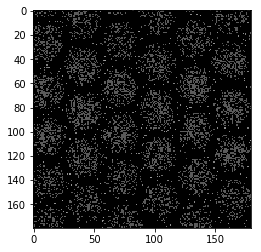

In [57]:
from PIL import Image, ImageDraw
filename = "C:/Users/toranj/Desktop/DL Python/SEM of Nanoparticles/8.png"
i = Image.open(filename)
i =np.array(i)
i = sharpen(i,0.9)
plt.imshow(i)